Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Outputs will be saved to: /content/drive/MyDrive/vaccine_sentiment_outputs
NLTK resources loaded successfully
Dataset loaded successfully with 11020 rows and 16 columns

Dataset columns:
['id', 'user_name', 'user_location', 'user_description', 'user_created', 'user_followers', 'user_friends', 'user_favourites', 'user_verified', 'date', 'text', 'hashtags', 'source', 'retweets', 'favorites', 'is_retweet']

First few rows:
                    id             user_name              user_location  \
0  1340539111971516416            Rachel Roh  La Crescenta-Montrose, CA   
1  1338158543359250433           Albert Fong          San Francisco, CA   
2  1337858199140118533              eli🇱🇹🇪🇺👌                   Your Bed   
3  1337855739918835717         Charles Adler     Vancouver, BC - Canada   
4  1337854064604966912  Citizen News Channel   

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Processed 0/11020 tweets...
Processed 5000/11020 tweets...
Processed 10000/11020 tweets...
Removed 89 rows with empty text after preprocessing
Removed 875 duplicate tweets
Applying stemming...
Generating sentiment scores using TextBlob...

Sentiment distribution:
sentiment
Neutral     4985
Positive    4187
Negative     884
Name: count, dtype: int64


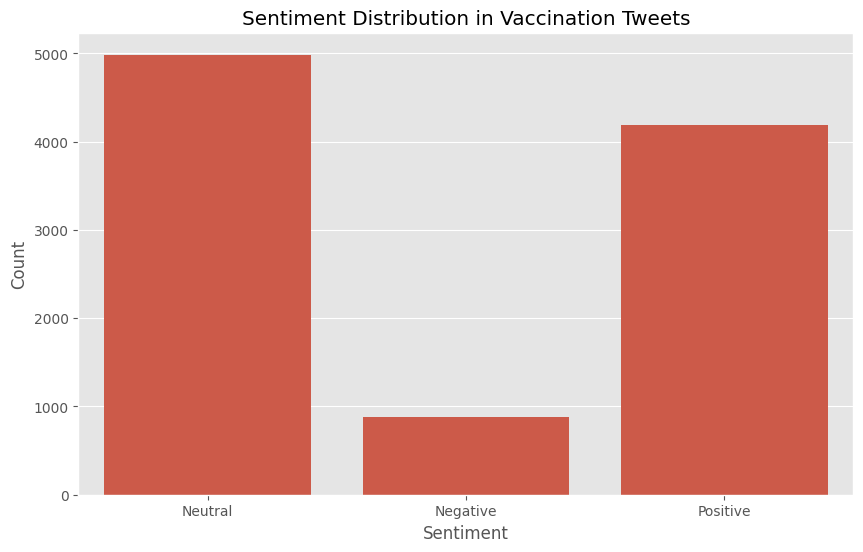

Generating word clouds by sentiment...


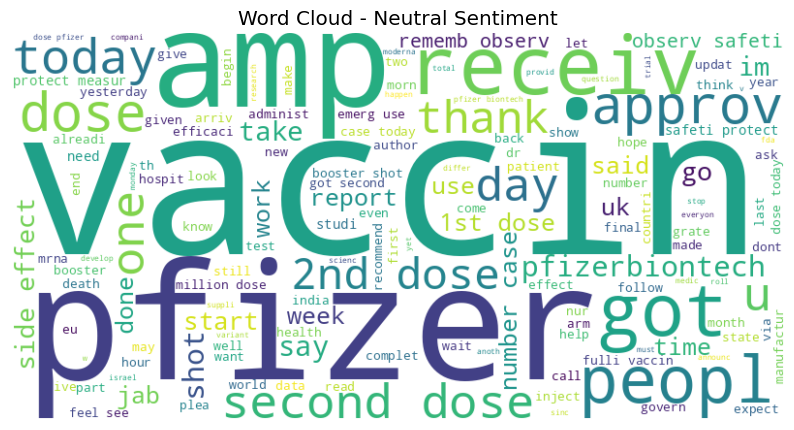

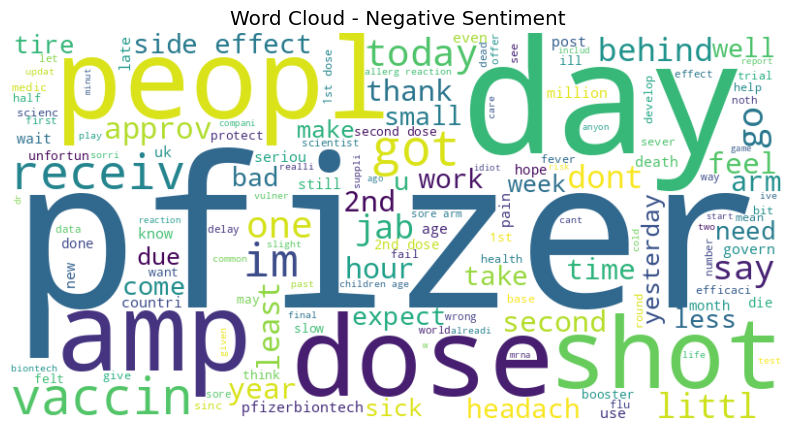

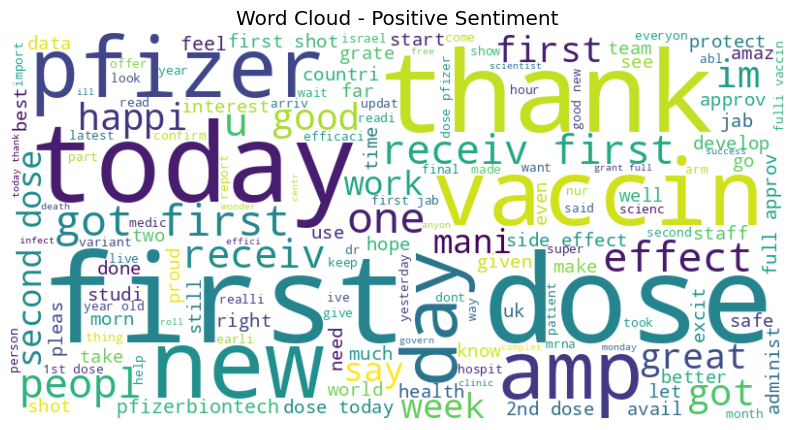

Vectorizing text data...
Training data shape: (8044, 5000)
Testing data shape: (2012, 5000)

Class distribution in training set:
sentiment
Neutral     0.495773
Positive    0.416335
Negative    0.087892
Name: proportion, dtype: float64
Applying SMOTE to balance classes...
After SMOTE, class distribution:
sentiment
Neutral     0.333333
Positive    0.333333
Negative    0.333333
Name: proportion, dtype: float64

Training models...
Training Logistic Regression model...
Best logistic regression parameters: {'C': 10.0, 'class_weight': 'balanced', 'solver': 'liblinear'}

Logistic Regression Results:
Training Accuracy: 0.9559
Test Accuracy: 0.7530

Training Random Forest model...
Best random forest parameters: {'class_weight': None, 'max_depth': None, 'n_estimators': 200}

Random Forest Results:
Training Accuracy: 0.9986
Test Accuracy: 0.8032

Random Forest performs better. Using it as the final model.

Classification Report:
              precision    recall  f1-score   support

    Negative  

<Figure size 1000x800 with 0 Axes>

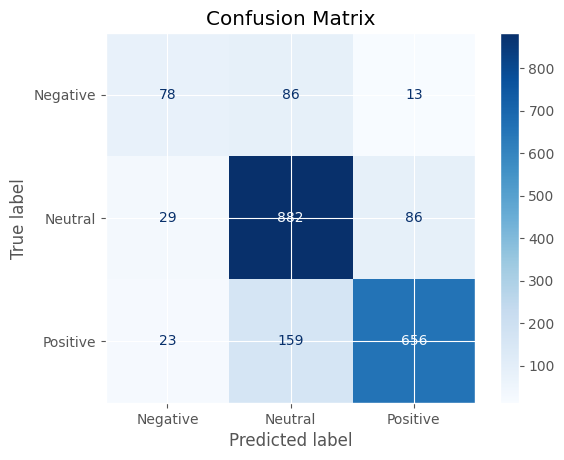

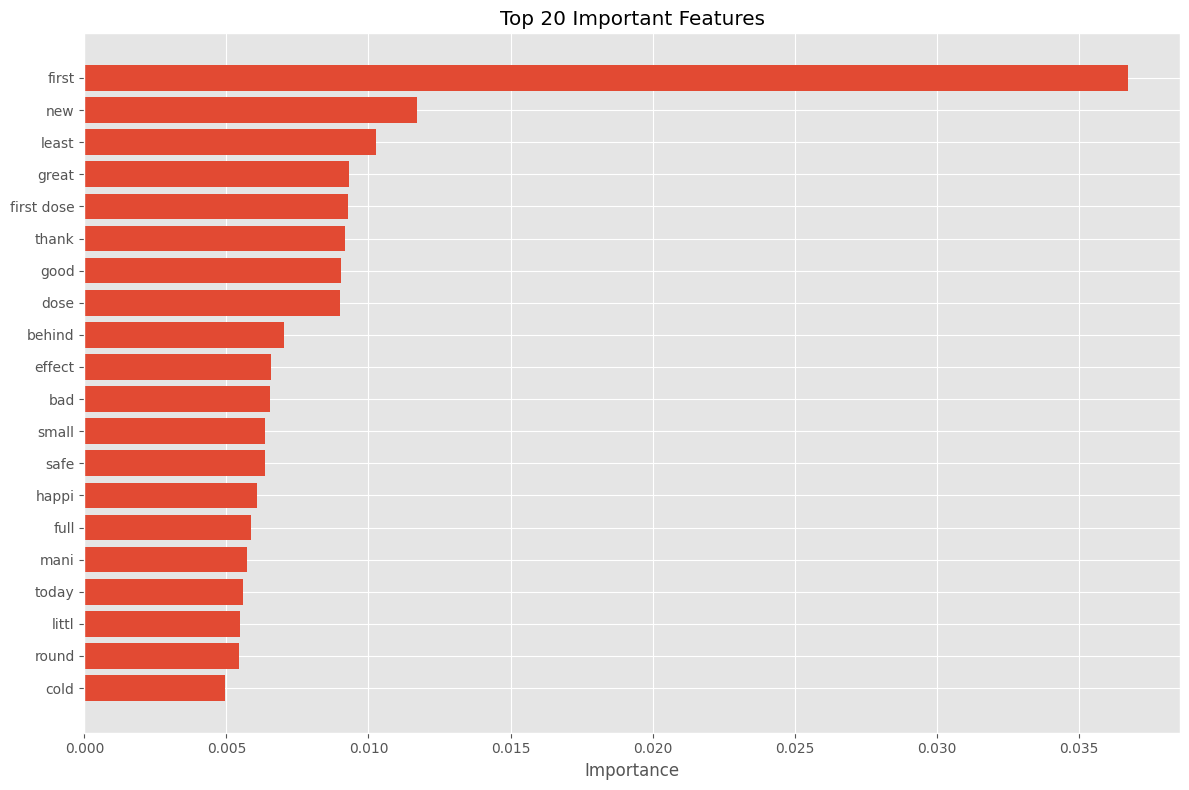


Saving model and vectorizer to Google Drive...

All outputs have been saved to Google Drive at:
/content/drive/MyDrive/vaccine_sentiment_outputs


In [ ]:
# Install necessary packages
!pip install textblob wordcloud nltk pandas numpy seaborn matplotlib scikit-learn imbalanced-learn

# Import required libraries
import nltk
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
from textblob import TextBlob
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import pickle
import os
from google.colab import drive, files

# Mount Google Drive for saving outputs
print("Mounting Google Drive...")
drive.mount('/content/drive')
output_dir = '/content/drive/MyDrive/vaccine_sentiment_outputs'
os.makedirs(output_dir, exist_ok=True)
print(f"Outputs will be saved to: {output_dir}")

print("Downloading NLTK resources...")
nltk.download('punkt')
nltk.download('stopwords')

try:
    stop_words = set(stopwords.words('english'))
    print("NLTK resources loaded successfully")
except Exception as e:
    print(f"Error loading NLTK resources: {e}")
    nltk.download('all')
    stop_words = set(stopwords.words('english'))

vaccine_stop_words = ['vaccine', 'vaccination', 'vaccines', 'covid', 'covid19', 'coronavirus']
stop_words.update(vaccine_stop_words)

df = pd.read_csv('vaccination_tweets.csv')
print(f"Dataset loaded successfully with {df.shape[0]} rows and {df.shape[1]} columns")

# Display dataset info
print("\nDataset columns:")
print(df.columns.tolist())
print("\nFirst few rows:")
print(df.head())

# Check if the dataset already has sentiment labels
has_sentiment_labels = 'sentiment' in df.columns or 'label' in df.columns

# Create a working dataframe with relevant columns
if 'text' not in df.columns:
    text_col = input("Enter the name of the column containing tweet text: ")
else:
    text_col = 'text'

if has_sentiment_labels:
    sentiment_col = 'sentiment' if 'sentiment' in df.columns else 'label'
    text_df = df[[text_col, sentiment_col]].copy()
    text_df.rename(columns={text_col: 'text'}, inplace=True)
    print(f"Using existing sentiment labels from column: {sentiment_col}")
else:
    text_df = df[[text_col]].copy()
    text_df.rename(columns={text_col: 'text'}, inplace=True)
    print("No sentiment labels found. Will generate using TextBlob.")

# Drop rows with missing text
text_df = text_df.dropna(subset=['text'])
initial_count = len(text_df)

# Text preprocessing function
def preprocess_text(text):
    """Clean and normalize text data"""
    if not isinstance(text, str):
        return "", 0

    text = text.lower()

    text = re.sub(r"https?://\S+|www\.\S+", '', text)

    text = re.sub(r'\@\w+|\#\w+', '', text)

    emoji_sentiment = 0
    if '😊' in text or '👍' in text or '❤️' in text:
        emoji_sentiment = 1
    elif '😠' in text or '👎' in text or '😢' in text:
        emoji_sentiment = -1


    text = re.sub(r'[^\w\s]', '', text)


    try:
        text_tokens = word_tokenize(text)
    except:
        # Fallback to simple split
        text_tokens = text.split()

    filtered_text = [w for w in text_tokens if w not in stop_words]

    return " ".join(filtered_text), emoji_sentiment

print("Preprocessing text...")
text_df['emoji_sentiment'] = 0
text_df['processed_text'] = ""

batch_size = 1000
for i in range(0, len(text_df), batch_size):
    batch = text_df.iloc[i:i+batch_size].copy()
    for idx, row in batch.iterrows():
        processed, emoji_sent = preprocess_text(row['text'])
        text_df.at[idx, 'processed_text'] = processed
        text_df.at[idx, 'emoji_sentiment'] = emoji_sent


    if i % 5000 == 0:
        print(f"Processed {i}/{len(text_df)} tweets...")


text_df = text_df[text_df['processed_text'].str.strip() != ""]
print(f"Removed {initial_count - len(text_df)} rows with empty text after preprocessing")

before_dedup = len(text_df)
text_df = text_df.drop_duplicates(subset=['processed_text'])
print(f"Removed {before_dedup - len(text_df)} duplicate tweets")

print("Applying stemming...")
stemmer = PorterStemmer()

def stem_text(text):
    """Apply stemming to each word in text"""
    if not isinstance(text, str):
        return ""
    return " ".join([stemmer.stem(word) for word in text.split()])

text_df['stemmed_text'] = text_df['processed_text'].apply(stem_text)

# Generate sentiment scores and labels if not already present
if not has_sentiment_labels:
    print("Generating sentiment scores using TextBlob...")

    def get_polarity(text):
        """Get TextBlob sentiment polarity"""
        return TextBlob(text).sentiment.polarity

    text_df['polarity'] = text_df['text'].apply(get_polarity)

    text_df['polarity'] = text_df.apply(lambda x: (x['polarity'] * 0.8) + (x['emoji_sentiment'] * 0.2), axis=1)

    # Create sentiment labels
    def get_sentiment(polarity):
        if polarity < -0.05:
            return 'Negative'
        elif polarity > 0.05:
            return 'Positive'
        else:
            return 'Neutral'

    text_df['sentiment'] = text_df['polarity'].apply(get_sentiment)
else:
    if 'sentiment' not in text_df.columns:
        text_df.rename(columns={sentiment_col: 'sentiment'}, inplace=True)

# Visualize sentiment distribution
print("\nSentiment distribution:")
sentiment_counts = text_df['sentiment'].value_counts()
print(sentiment_counts)

plt.figure(figsize=(10, 6))
sns.countplot(x='sentiment', data=text_df)
plt.title('Sentiment Distribution in Vaccination Tweets')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.savefig(f'{output_dir}/sentiment_distribution.png')
plt.show()

# Generate word clouds for each sentiment
print("Generating word clouds by sentiment...")
for sentiment in text_df['sentiment'].unique():
    sentiment_text = " ".join(text_df[text_df['sentiment'] == sentiment]['stemmed_text'])

    if sentiment_text.strip():
        wordcloud = WordCloud(width=800, height=400,
                             background_color='white',
                             max_words=150).generate(sentiment_text)

        plt.figure(figsize=(10, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Word Cloud - {sentiment} Sentiment')
        plt.savefig(f'{output_dir}/wordcloud_{sentiment.lower()}.png')
        plt.show()

print("Vectorizing text data...")
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    min_df=2,
    max_df=0.85,
    ngram_range=(1, 2)
)

X = tfidf_vectorizer.fit_transform(text_df['stemmed_text'])
y = text_df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

print("\nClass distribution in training set:")
train_class_dist = pd.Series(y_train).value_counts(normalize=True)
print(train_class_dist)

# Apply SMOTE for imbalanced classes if needed
if min(train_class_dist) < 0.25:
    print("Applying SMOTE to balance classes...")
    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)
    print("After SMOTE, class distribution:")
    print(pd.Series(y_train).value_counts(normalize=True))

# Model training using grid search for hyperparameter tuning
print("\nTraining models...")

# Logistic Regression
print("Training Logistic Regression model...")
logreg_params = {
    'C': [0.1, 1.0, 10.0],
    'class_weight': [None, 'balanced'],
    'solver': ['liblinear', 'saga']
}

logreg_grid = GridSearchCV(
    LogisticRegression(max_iter=1000),
    logreg_params,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1
)

logreg_grid.fit(X_train, y_train)
logreg_best = logreg_grid.best_estimator_

print(f"Best logistic regression parameters: {logreg_grid.best_params_}")
logreg_train_pred = logreg_best.predict(X_train)
logreg_test_pred = logreg_best.predict(X_test)

print("\nLogistic Regression Results:")
print(f"Training Accuracy: {accuracy_score(y_train, logreg_train_pred):.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, logreg_test_pred):.4f}")

# Random Forest (as a comparison model)
print("\nTraining Random Forest model...")
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'class_weight': [None, 'balanced']
}

rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    rf_params,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1
)

rf_grid.fit(X_train, y_train)
rf_best = rf_grid.best_estimator_

print(f"Best random forest parameters: {rf_grid.best_params_}")
rf_train_pred = rf_best.predict(X_train)
rf_test_pred = rf_best.predict(X_test)

print("\nRandom Forest Results:")
print(f"Training Accuracy: {accuracy_score(y_train, rf_train_pred):.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, rf_test_pred):.4f}")

# Compare and select the best model
logreg_accuracy = accuracy_score(y_test, logreg_test_pred)
rf_accuracy = accuracy_score(y_test, rf_test_pred)

if rf_accuracy > logreg_accuracy:
    print("\nRandom Forest performs better. Using it as the final model.")
    best_model = rf_best
    y_pred = rf_test_pred
else:
    print("\nLogistic Regression performs better. Using it as the final model.")
    best_model = logreg_best
    y_pred = logreg_test_pred

# Detailed evaluation of the best model
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_).plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.savefig(f'{output_dir}/confusion_matrix.png')
plt.show()

# Feature importance analysis
if isinstance(best_model, RandomForestClassifier):
    # For Random Forest
    feature_importances = best_model.feature_importances_
    feature_names = tfidf_vectorizer.get_feature_names_out()

    top_features_idx = feature_importances.argsort()[-20:]
    top_features = [(feature_names[i], feature_importances[i]) for i in top_features_idx]

    plt.figure(figsize=(12, 8))
    plt.barh([name for name, _ in top_features], [importance for _, importance in top_features])
    plt.xlabel('Importance')
    plt.title('Top 20 Important Features')
    plt.tight_layout()
    plt.savefig(f'{output_dir}/feature_importance.png')
    plt.show()
else:
    # For Logistic Regression
    feature_names = tfidf_vectorizer.get_feature_names_out()

    # Get coefficients for each class
    for i, sentiment_class in enumerate(best_model.classes_):
        if len(best_model.classes_) <= 2 and i == 0:
            # For binary classification, sklearn only stores one set of coefficients
            continue

        coef_idx = i if len(best_model.classes_) > 2 else 0
        coefficients = best_model.coef_[coef_idx]

        top_positive_idx = coefficients.argsort()[-10:]
        top_negative_idx = coefficients.argsort()[:10]

        top_positive = [(feature_names[i], coefficients[i]) for i in top_positive_idx]
        top_negative = [(feature_names[i], coefficients[i]) for i in top_negative_idx]

        plt.figure(figsize=(12, 8))
        plt.subplot(1, 2, 1)
        plt.barh([name for name, _ in top_positive], [coef for _, coef in top_positive], color='green')
        plt.xlabel('Coefficient')
        plt.title(f'Top Positive Features for {sentiment_class}')

        plt.subplot(1, 2, 2)
        plt.barh([name for name, _ in top_negative], [coef for _, coef in top_negative], color='red')
        plt.xlabel('Coefficient')
        plt.title(f'Top Negative Features for {sentiment_class}')

        plt.tight_layout()
        plt.savefig(f'{output_dir}/feature_importance_{sentiment_class}.png')
        plt.show()

# Save the trained model and vectorizer for later use
print("\nSaving model and vectorizer to Google Drive...")
with open(f'{output_dir}/vaccine_sentiment_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

with open(f'{output_dir}/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)


def predict_sentiment(input_text):
    """
    Predict sentiment for new text input
    """
    # Preprocess input text
    processed_text, emoji_sent = preprocess_text(input_text)

    stemmed_text = stem_text(processed_text)

    vector = tfidf_vectorizer.transform([stemmed_text])

    prediction = best_model.predict(vector)[0]

    # Get confidence score
    if hasattr(best_model, 'predict_proba'):
        probas = best_model.predict_proba(vector)[0]
        confidence = max(probas)
        confidence_dict = {class_name: proba for class_name, proba in zip(best_model.classes_, probas)}
    else:
        confidence = 1.0  # Default if model doesn't support probabilities
        confidence_dict = {prediction: 1.0}

    emoji_analysis = ""
    if emoji_sent > 0:
        emoji_analysis = " (Positive emoji detected)"
    elif emoji_sent < 0:
        emoji_analysis = " (Negative emoji detected)"

    return {
        'prediction': prediction,
        'confidence': confidence,
        'class_probabilities': confidence_dict,
        'emoji_analysis': emoji_analysis
    }

from ipywidgets import widgets
from IPython.display import display, clear_output

def analyze_text(text):
    if not text.strip():
        return "Please enter some text to analyze."

    result = predict_sentiment(text)

    output = f"Predicted Sentiment: {result['prediction']} (Confidence: {result['confidence']:.2f}){result['emoji_analysis']}\n\n"
    output += "Class Probabilities:\n"
    for sentiment, probability in result['class_probabilities'].items():
        output += f"  {sentiment}: {probability:.4f}\n"

    if len(text.split()) > 5:
        processed, _ = preprocess_text(text)
        terms = processed.split()
        if terms:
            output += "\nKey terms in your text:\n"
            output += ", ".join(terms[:5])

    return output

# Create widgets
text_area = widgets.Textarea(
    value='',
    placeholder='Type a tweet or statement about vaccines to analyze its sentiment',
    description='Text:',
    disabled=False,
    layout=widgets.Layout(width='80%', height='100px')
)

analyze_button = widgets.Button(
    description='Analyze Sentiment',
    disabled=False,
    button_style='primary',
    tooltip='Click to analyze the text',
    icon='check'
)

output_area = widgets.Output()

def on_button_clicked(b):
    with output_area:
        clear_output()
        print(analyze_text(text_area.value))

analyze_button.on_click(on_button_clicked)

print("\nAll outputs have been saved to Google Drive at:")
print(output_dir)

In [ ]:
# Display the widgets
print("Enter text about vaccines and click 'Analyze Sentiment' to predict its sentiment:")
display(text_area)
display(analyze_button)
display(output_area)

Enter text about vaccines and click 'Analyze Sentiment' to predict its sentiment:


Textarea(value='', description='Text:', layout=Layout(height='100px', width='80%'), placeholder='Type a tweet …

Button(button_style='primary', description='Analyze Sentiment', icon='check', style=ButtonStyle(), tooltip='Cl…

Output()